In [1]:
import torch

In [2]:
print("PyTorch HIP Version:", torch.version.hip)  # Should return the ROCm version
print("Is CUDA available?:", torch.cuda.is_available())  # Should return True
print("CUDA Device Name:", torch.cuda.get_device_name(0))  # Should return "AMD Instinct MI250X"

PyTorch HIP Version: 5.4.22803-474e8620
Is CUDA available?: True
CUDA Device Name: AMD Instinct MI250X


In [3]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import io

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision.transforms as transforms
import torchvision.models as models

import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

In [4]:
PATH = 'dataset/'

# Dataset

After a vizualisation of our dataset, we notice a strong class imbalance. To correct this, we downsample the majority class up to a similar number of samples as the majority class. Then we split the dataset in training, validation and test set. Thanks to a custom class, we build a PyTorch dataset. 

## Data vizualisation

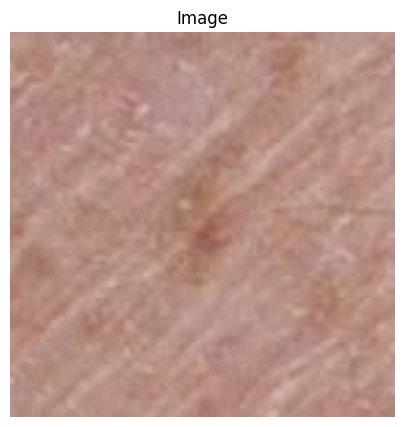

In [5]:
# Function to display the image
def show_image(image):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)  
    plt.title('Image')
    plt.axis('off')
    plt.show()

# Load the image from the image folder
image_path = os.path.join(PATH, 'train-image/image/ISIC_0015670.jpg')
image = Image.open(image_path)
show_image(image)

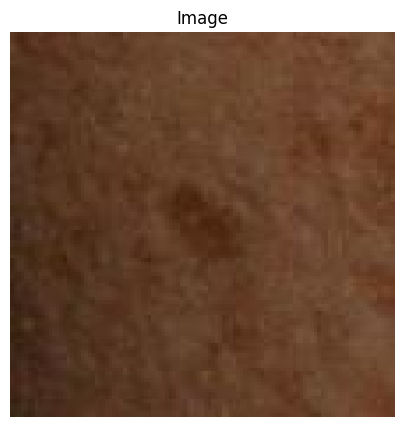

In [6]:
# Load the image from the .hdf5 
train_image_path = os.path.join(PATH, 'train-image.hdf5')

# Open the folder and display one image
with h5py.File(train_image_path, 'r') as hdf5_file:
    keys = list(hdf5_file.keys())
    image_data = hdf5_file[keys[3]][()]  # Access the first image
    image = Image.open(io.BytesIO(image_data)) 
    show_image(image)

In [7]:
train_metadata_path = os.path.join(PATH, 'train-metadata.csv')
metadata = pd.read_csv(train_metadata_path)

metadata.head(5)

/tmp/ipykernel_15740/3766176874.py:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(train_metadata_path)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


## Class Imbalance

In [8]:
# counting the occurence of the two classes
target_counts = metadata['target'].value_counts()
print(target_counts)

target
0    400666
1       393
Name: count, dtype: int64


In [9]:
## Solution --> downsampling of the majority class
from sklearn.utils import resample

factor = 1 
minority_class = metadata[metadata['target'] == 1]
majority_class = metadata[metadata['target'] == 0]
maj_downsampled = resample(majority_class, replace=False, n_samples=len(minority_class)*factor)

# balanced metadata
metadata = pd.concat([maj_downsampled, minority_class])

In [10]:
# counting the occurence of the two classes after downsampling
target_counts = metadata['target'].value_counts()
print(target_counts)

target
0    393
1    393
Name: count, dtype: int64


## Create a Dataset class

In [11]:
# Create a class for the dataset from the hdf5 folder
class isicDataset(Dataset):
    def __init__(self, hdf5_path, metadata, transform_image = None):
        self.hdf5_path = hdf5_path
        self.metadata = metadata
        self.transform_image = transform_image
                        
            
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        metadata_row = self.metadata.iloc[idx]
        isic_id = metadata_row['isic_id']
        label = metadata_row['target']
        with h5py.File(self.hdf5_path, 'r') as hdf5_file:
            bytes_img = hdf5_file[isic_id][()]
            image = Image.open(io.BytesIO(bytes_img)).convert('RGB')

            if self.transform_image:
                image = self.transform_image(image)

        return image, label

## Spilt dataset

In [12]:
total_size = metadata.shape[0] # output rows, columns
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size
train_idx, val_idx, test_idx = random_split(metadata.index, [train_size, val_size, test_size])

print(train_idx[4])

# Size of the datasets
print(f"Dataset size = {total_size}")
print(f"Training set size = {len(train_idx)}")
print(f"Validation set size = {len(val_idx)}")
print(f"Testing set size = {len(test_idx)}")

282583
Dataset size = 786
Training set size = 550
Validation set size = 157
Testing set size = 79


In [13]:
train_metadata = metadata.iloc[train_idx.indices]
val_metadata = metadata.iloc[val_idx.indices]
test_metadata = metadata.iloc[test_idx.indices]

In [14]:
# Verify the number of occurence of the classes in the train and val dataset

target_counts = train_metadata['target'].value_counts()
print(target_counts)

target_counts = val_metadata['target'].value_counts()
print(target_counts)

target
1    281
0    269
Name: count, dtype: int64
target
0    85
1    72
Name: count, dtype: int64


## Data transformation

In [15]:
# Zoom, Rotation, Rescale, Normalization
input_size = 224    # value choosen to match resnet18

transformTrain = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),  
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    # normalization fixed by the resnet18
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
    ])


transformVal = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


transformTest = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [16]:
train_metadata_path = os.path.join(PATH, 'train-metadata.csv')

train_imageDataset = isicDataset(train_image_path, train_metadata, transformTrain)
val_imageDataset   = isicDataset(train_image_path, val_metadata, transformVal)
test_imageDataset   = isicDataset(train_image_path, test_metadata, transformTest)

## DataLoader

In [17]:

batch_size = 16 #64

train_loader = DataLoader(train_imageDataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_imageDataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_imageDataset, batch_size=batch_size, shuffle=False)

print(f"Training set size = {len(train_loader)}")
print(f"Validation set size = {len(val_loader)}")
print(f"Testing set size = {len(test_loader)}")

Training set size = 35
Validation set size = 10
Testing set size = 5


# Model

We use transfer learning to take advantage of the knowledge acquire with the ImageNet classication task. We use the resnet18 (18 layers), which is the smallest pretrained resnet available on PyTorch. We use the smallest as we have a limited number of images due to the downsampling. All the parameters are freezed and the last layer is replaced by a fully connected layer with an output size of 2 (to fit our 2 classes classification).  

## Model definition

In [18]:
### From w6 lecture on transfer learning, slide 30 ###

num_classes = 2

# Load the pretrained model
resnet = models.resnet18(pretrained=True)

# freeze parameters
for param in resnet.parameters():
    param.requires_grad = False

# overwrite the 'fc' layer
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, num_classes)

# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

# find parameters to update
params_to_update = []
for name,param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

# define the SGD optimizer
optimizer = optim.SGD(params_to_update, lr = 0.001, momentum = 0.9)

/pfs/lustref1/flash/project_465001560/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/pfs/lustref1/flash/project_465001560/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Training

In [19]:
import time
import copy

### Adapted from w6_transfer2_students ###
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []
    train_acc_history=[]

    val_loss_history = []
    train_loss_history=[]

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    #evaluate before training:
    model.eval()   # Set model to evaluate mode

    running_corrects = 0
    for inputs, labels in dataloaders['train']:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)      
      _, preds = torch.max(outputs, 1)

      running_corrects += torch.sum(preds == labels.data)

    acc = running_corrects.double() / len(dataloaders['train'].dataset)
    train_acc_history.append(acc)
    print('train acc:',acc)

    running_corrects = 0
    for inputs, labels in dataloaders['val']:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)       
      _, preds = torch.max(outputs, 1)
      running_corrects += torch.sum(preds == labels.data)

    acc = running_corrects.double() / len(dataloaders['val'].dataset)
    val_acc_history.append(acc)
    print('val acc:',acc)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):          
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, val_loss_history, train_loss_history

In [20]:
num_epochs = 50
dataloaders_dict = {}
dataloaders_dict['train'] = train_loader
dataloaders_dict['val'] = val_loader

# Setup the loss fxn in case the factor is different to 1
y = train_metadata['target']
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
weightsTensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# cross entropy loss function with specified weights
criterion = nn.CrossEntropyLoss(weight=weightsTensor)

In [21]:
model_ft, hist_val, hist_train, val_loss, train_loss = train_model(resnet, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

train acc: tensor(0.5091, device='cuda:0', dtype=torch.float64)
val acc: tensor(0.4522, device='cuda:0', dtype=torch.float64)
Epoch 0/49
----------
train Loss: 0.7038 Acc: 0.5564
val Loss: 0.6323 Acc: 0.6624

Epoch 1/49
----------
train Loss: 0.7255 Acc: 0.6200
val Loss: 0.7163 Acc: 0.5732

Epoch 2/49
----------
train Loss: 0.6097 Acc: 0.6655
val Loss: 0.5721 Acc: 0.7070

Epoch 3/49
----------
train Loss: 0.5752 Acc: 0.7200
val Loss: 0.7644 Acc: 0.6369

Epoch 4/49
----------
train Loss: 0.5451 Acc: 0.7236
val Loss: 0.5724 Acc: 0.7006

Epoch 5/49
----------
train Loss: 0.5371 Acc: 0.7345
val Loss: 0.5241 Acc: 0.7325

Epoch 6/49
----------
train Loss: 0.5556 Acc: 0.7255
val Loss: 0.5608 Acc: 0.7134

Epoch 7/49
----------
train Loss: 0.5180 Acc: 0.7473
val Loss: 0.5388 Acc: 0.7389

Epoch 8/49
----------
train Loss: 0.5003 Acc: 0.7600
val Loss: 0.5023 Acc: 0.7707

Epoch 9/49
----------
train Loss: 0.5249 Acc: 0.7600
val Loss: 0.5043 Acc: 0.7580

Epoch 10/49
----------
train Loss: 0.5064 Ac

# Results

To analyse the results, we use the accuracy and loss across the epochs for the validation and training set. After, we compute performance metrics (accuracy, precision, recall, F1 score and confusion matrix) on the test set (unseen data for the model). 

### Accuracy and loss across epochs

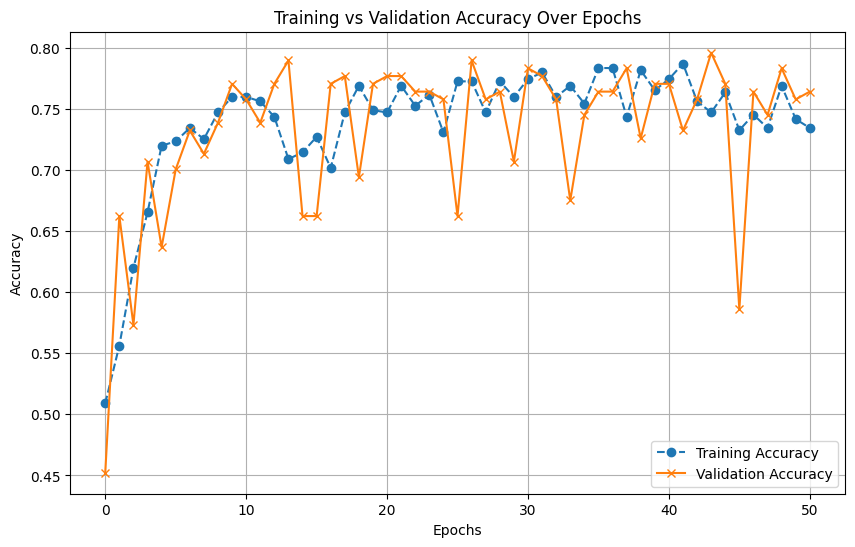

In [32]:
import matplotlib.pyplot as plt

# Training vs Validation Accuracy
plt.figure(figsize=(10, 6))
train_accs = [x.cpu().numpy() for x in hist_train]  # Convert tensor values to NumPy
train_accs = np.array(train_accs)
plt.plot(train_accs, label='Training Accuracy', marker='o', linestyle='--')

val_accs = [x.cpu().numpy() for x in hist_val]  # Convert tensor values to NumPy
val_accs = np.array(val_accs)
plt.plot(val_accs, label='Validation Accuracy', marker='x', linestyle='-')

plt.title("Training vs Validation Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

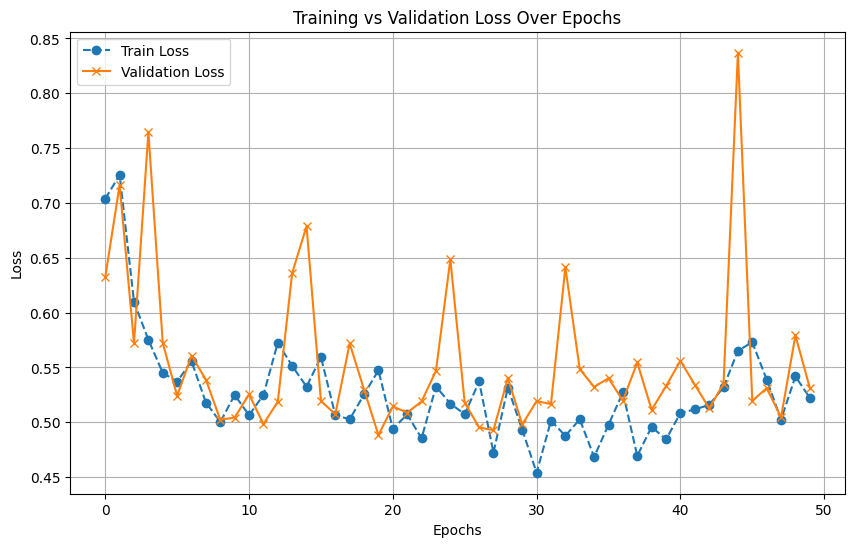

In [33]:
# Plot Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss', marker='o', linestyle='--')
plt.plot(val_loss, label='Validation Loss', marker='x', linestyle='-')
plt.title("Training vs Validation Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

### Performance on test set

In [34]:
y_true = []
y_pred = []

model_ft.eval()

# Iterate over the validation or test dataloader
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)  # Get the index of the max probability

        y_true.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy
        y_pred.extend(preds.cpu().numpy())

In [35]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted') 
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.6962
Precision: 0.7087
Recall: 0.6962
F1 Score: 0.6907


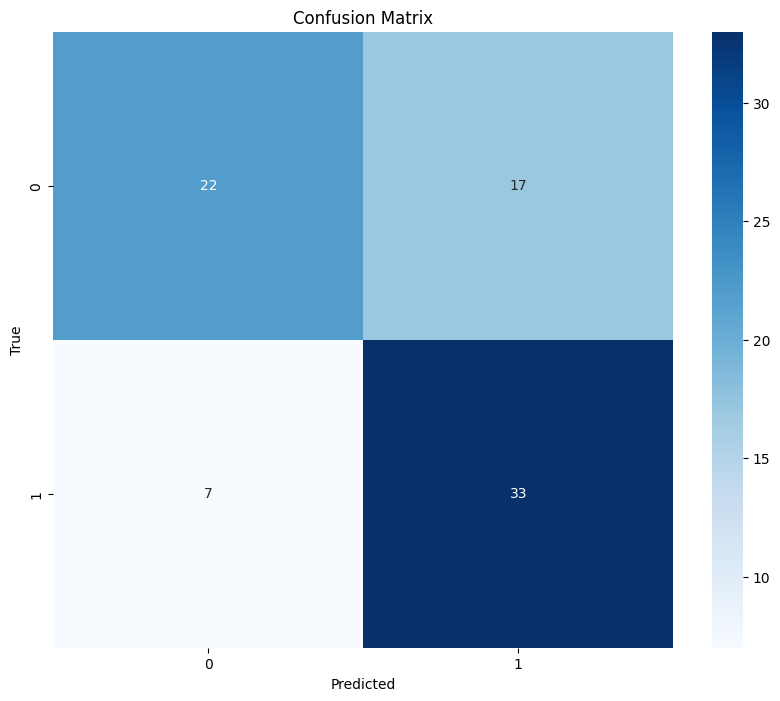

In [36]:
classes = [0,1]
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()